#Boring imports and loading

In [ ]:
!pip install numpy==1.25.0
!pip install cupy-cuda11x
%pip install transformers datasets git+https://github.com/neelnanda-io/TransformerLens.git circuitsvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-rss1ogko
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-rss1ogko
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit f5a7d455546a88cfdfb26e781d5bd6447e8243eb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import dataclasses
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
from fancy_einsum import einsum
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    AutoConfig
)

# TransformerLens specific imports
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache
)

In [ ]:
model = HookedTransformer.from_pretrained('roneneldan/TinyStories-1M')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
dataset = load_dataset("roneneldan/TinyStoriesInstruct")

Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer
Moving model to device:  cpu


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

#Creating lists of N-V-A tokens

In [ ]:
i = 0
verbs = set()
nouns = set()
adjectives = set()
words = set()
for example in dataset["train"]:
    i+=1
    if i > 100000: break #maxes out on new words here--add another 0 if you don't believe me
    string = example["text"]
    if string[0:7] == "Words: ":
        word_list = string[7:]  # Remove the "Words: " prefix
        individual_words = word_list.split(', ')
        words.update(individual_words)
        verbs.add(individual_words[0])
        nouns.add(individual_words[1])
        adjectives.add(individual_words[2])
print(len(nouns), len(verbs), len(adjectives), len(nouns)+ len(verbs)+ len(adjectives))


1066 394 245 1705


In [ ]:
print(len(nouns), len(verbs), len(adjectives), len(nouns)+ len(verbs)+ len(adjectives))
print(len(words))

verbs_only = (verbs - nouns) - adjectives
nouns_only = (nouns - verbs) - adjectives
adjectives_only = (adjectives - verbs) - nouns
leftovers = words - verbs_only - nouns_only - adjectives_only

print(leftovers)
print(len(nouns_only), len(verbs_only), len(adjectives_only), len(nouns_only)+ len(verbs_only)+ len(adjectives_only))

1066 394 245 1705
1603
{'yellow', 'tie', 'fall', 'jog', 'pass', 'smile', 'speed', 'promise', 'wrap', 'pick', 'sail', 'surprise', 'stand', 'escape', 'march', 'question', 'work', 'sack', 'zoom', 'wave', 'dry', 'spring', 'wake', 'green', 'watch', 'dark', 'black', 'test', 'nap', 'welcome', 'young', 'slide', 'love', 'value', 'look', 'white', 'seat', 'wet', 'stay', 'point', 'print', 'step', 'name', 'hot', 'paint', 'cut', 'store', 'mark', 'safe', 'sign', 'mail', 'whistle', 'turn', 'clean', 'blue', 'fly', 'walk', 'swing', 'worry', 'visit', 'hug', 'cold', 'wild', 'patient', 'open', 'search', 'fight', 'wide', 'touch', 'fit', 'order', 'park', 'swim', 'zip', 'quiet', 'pink', 'rock', 'dream', 'gray', 'teach', 'win', 'dress', 'number', 'purple', 'wonder', 'bow', 'old', 'joke', 'rub', 'race', 'orange', 'lock', 'taste', 'urge', 'play', 'light', 'start', 'dance', 'match', 'rain', 'measure'}
968 314 220 1502


In [ ]:
#create token_lists
token_lists = [[],[],[]]
accept_count = 0
for idx, bigset in enumerate([nouns_only, verbs_only, adjectives_only]):
    for word in bigset:
        word = " "+word
        candidate = tokenizer(word)
        print(candidate["input_ids"])
        if len(candidate["input_ids"]) == 1:
            token_lists[idx].append(candidate["input_ids"])
            accept_count +=1
        else: print("rejected ", word)
print(accept_count)

noun_tokens = token_lists[0]
verb_tokens = token_lists[1]
adj_tokens = token_lists[2]

[4252]
[8234]
[31812]
[3430]
[20922]
[40812]
[1994]
[24695]
[10000]
[3496]
[10283]
[12855]
[48241]
[1976, 37052]
rejected   zebra
[3809]
[29461]
[40562]
[25451]
[3869]
[6450]
[7660]
[5243]
[26473]
[33579]
[11620]
[4936]
[7415]
[34681, 461]
rejected   kayak
[3072]
[35822]
[6899]
[2657]
[3292]
[17026]
[19751]
[582]
[4269]
[7771]
[3931]
[13209]
[47565]
[26148]
[2493]
[6403]
[1641]
[30860]
[16569]
[15806]
[6947]
[3112]
[6842]
[9007]
[3807]
[7733]
[16383]
[19143]
[22749]
[781, 1133]
rejected   flute
[15050]
[33388]
[5916]
[12389]
[27142]
[10846]
[9230]
[4167]
[18550]
[11426]
[5337]
[17186]
[20712]
[12403]
[16134]
[640]
[1363]
[9260]
[30060]
[1255]
[13257]
[3159]
[10308]
[11376]
[34232]
[32263]
[36251]
[7093]
[30615]
[7838]
[22843, 12384]
rejected   cobweb
[30972, 353]
rejected   otter
[25510]
[17023]
[4205]
[49303]
[8824]
[20562]
[8245]
[11384]
[6473]
[6853]
[4314]
[18355]
[2119]
[9283]
[6297]
[5719]
[4168]
[15291]
[21615]
[26296]
[35715]
[28520]
[3956]
[6614]
[10876]
[7721]
[8223]
[11845]


#Finding initial embeddings

In [ ]:
# Function to embed a set of tokens and reshape the embedding tensor
def get_embeddings_and_reshape(model, token_set, embedding_dim=64):
    embeddings = model.embed(token_set)
    return embeddings.view(len(token_set), embedding_dim)

# Function to calculate vector norms
def calculate_vector_norms(embeddings):
    return torch.norm(embeddings, dim=1)

# Function to plot histograms of vector norms
def plot_vector_norm_histogram(vector_norms, title):
    plt.hist(vector_norms.detach().numpy(), bins=50)
    plt.xlabel('Vector Lengths')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

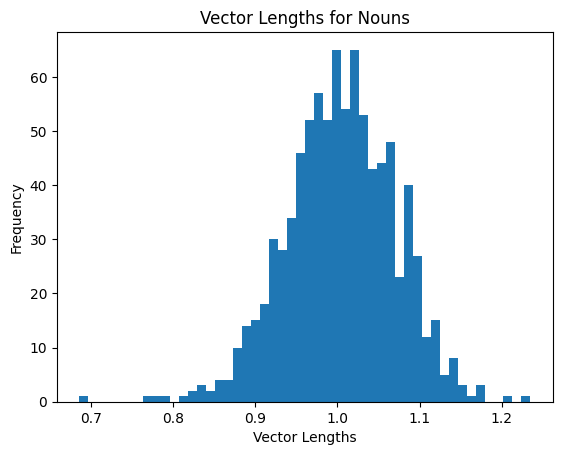

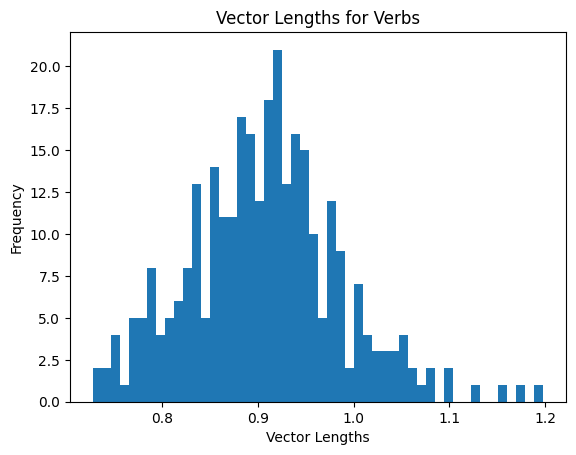

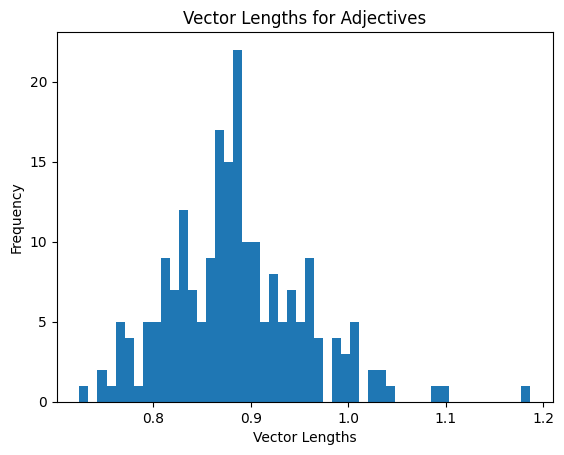

In [ ]:
# Embed tokens and reshape once, assuming the embedding size is consistent and 64
embedding_dim = 64  # This should be set to the actual embedding size of the model
token_sets = [noun_tokens, verb_tokens, adj_tokens]
embedded_tokens = [get_embeddings_and_reshape(model, token_set, embedding_dim) for token_set in token_sets]

# Calculate vector norms and plot histograms
for idx, embeddings in enumerate(embedded_tokens):
    vector_norms = calculate_vector_norms(embeddings)
    plot_vector_norm_histogram(vector_norms, f'Vector Lengths for {["Nouns", "Verbs", "Adjectives"][idx]}')

In [ ]:
torch.manual_seed(0)

train_embedded_tokens = []
val_embedded_tokens = []

for embeddings in embedded_tokens:
    # Randomly selecting indices for training and validation sets
    total_indices = embeddings.shape[0]
    rand_indices = torch.randperm(total_indices)
    train_indices = rand_indices[40:]
    val_indices = rand_indices[:40]

    # Splitting into training and validation sets
    train_embeddings = embeddings[train_indices]
    val_embeddings = embeddings[val_indices]

    train_embedded_tokens.append(train_embeddings)
    val_embedded_tokens.append(val_embeddings)

# Compute average embeddings
averages = [torch.mean(embeddings, dim=0) for embeddings in train_embedded_tokens]
val_averages = [torch.mean(embeddings, dim=0) for embeddings in val_embedded_tokens]

# Stacking average embeddings and checking shapes
avg_tensor = torch.stack(averages)
val_avg_tensor = torch.stack(val_averages)

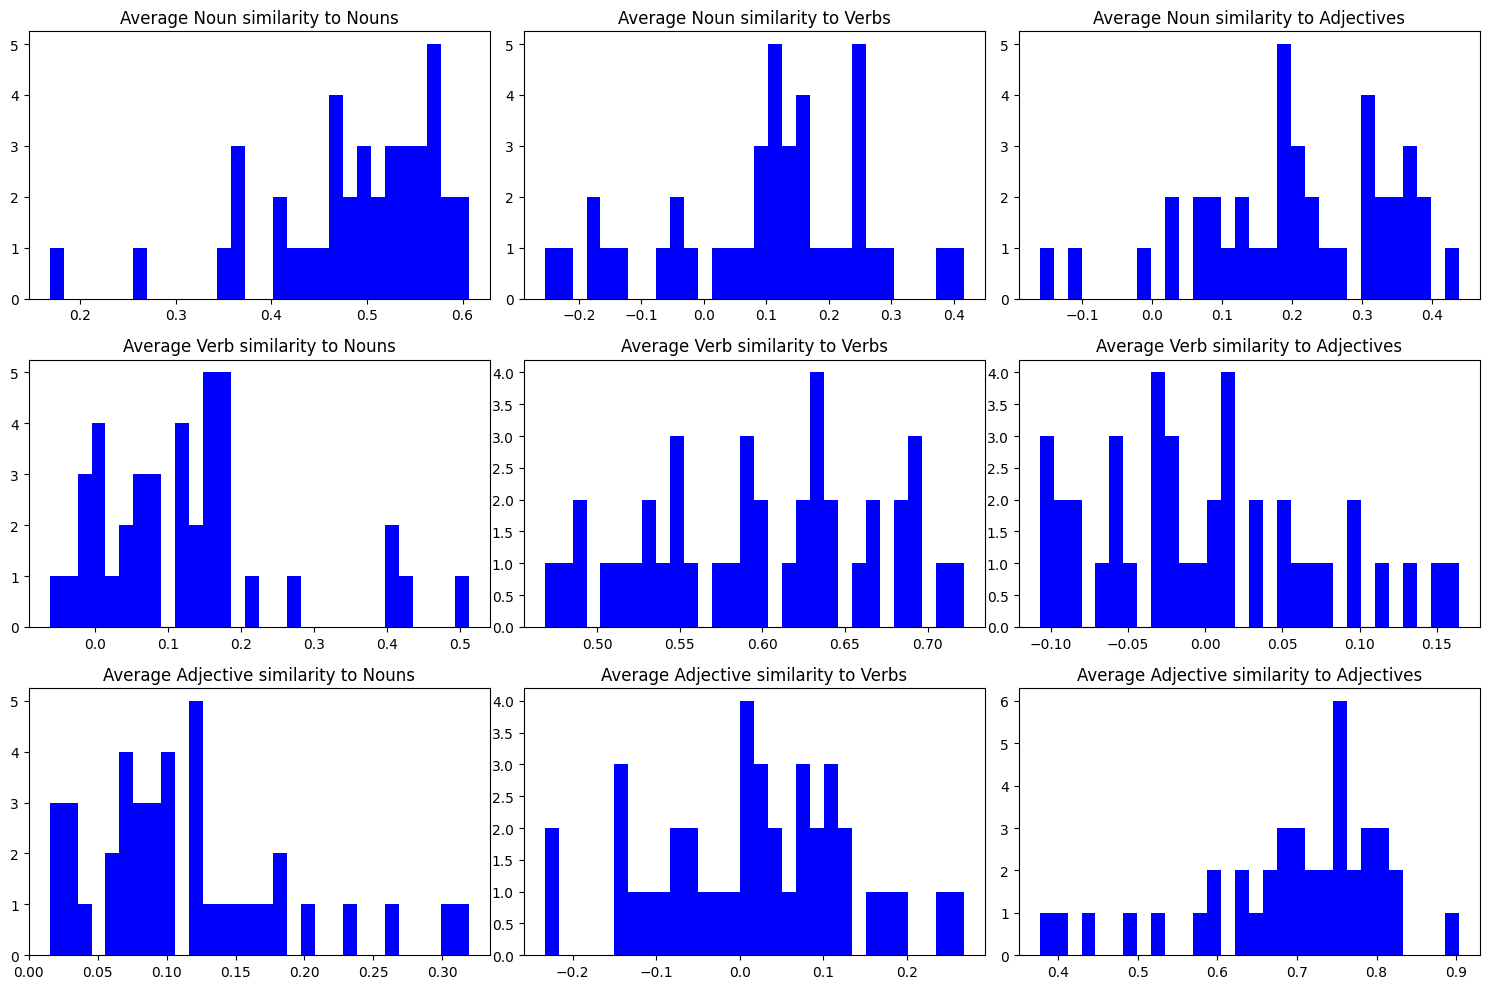

In [ ]:
# Cosine similarity and histogram plotting
plt.figure(figsize=(15, 10))
cosine_similarities = []
for avg_idx, avg_vector in enumerate(averages):
    for embed_idx, embeddings in enumerate(val_embedded_tokens):
        avg_vector_unsq = avg_vector.unsqueeze(0)  # Add extra dimension for cosine_similarity
        cosine_similarity = F.cosine_similarity(avg_vector_unsq, embeddings)
        cosine_similarities.append(cosine_similarity)
        plt.subplot(3, 3, avg_idx*3 + embed_idx + 1)
        plt.hist(cosine_similarity.detach().numpy().flatten(), bins=30, color='b')
        plt.title(f'Average {["Noun", "Verb", "Adjective"][avg_idx]} similarity to {["Nouns", "Verbs", "Adjectives"][embed_idx]}')
plt.tight_layout()
plt.show()

In [ ]:
# Magnitude of average vectors and cosine similarity between them
for i in range(len(averages)):
    print(f"Norm of average vector {['Noun', 'Verb', 'Adjective'][i]}: {torch.norm(averages[i])}")
    print(f"Cosine similarity between average {['Noun', 'Verb', 'Adjective'][i]} and {['Adjective', 'Noun', 'Verb'][i-1]}: {F.cosine_similarity(averages[i], averages[i-1], dim=0)}")


Norm of average vector Noun: 0.48090243339538574
Cosine similarity between average Noun and Verb: 0.23253533244132996
Norm of average vector Verb: 0.5294283628463745
Cosine similarity between average Verb and Adjective: 0.18126747012138367
Norm of average vector Adjective: 0.6233763694763184
Cosine similarity between average Adjective and Noun: 0.016030941158533096


#Making linear probes

In [ ]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

class ProbeTrainerModel(nn.Module):
    def __init__(self):
        super(ProbeTrainerModel, self).__init__()
        self.hooked_model = HookedTransformer.from_pretrained('roneneldan/TinyStories-1M')
        for param in self.hooked_model.parameters():
            param.requires_grad = False
        self.classifiers = nn.ModuleList([LinearProbe(64, 4) for _ in range(8)])
        self.other_class_weights = torch.mean(avg_tensor, dim=0).unsqueeze(0)  # or torch.zeros(1, 64)

        for classifier in self.classifiers:
            # Copy over the weights for the noun, verb, and adjective classes
            classifier.linear.weight.data[:3, :] = avg_tensor
            # Set the weights for the "other" class
            classifier.linear.weight.data[3, :] = -self.other_class_weights

    def forward(self, input_string, token_pos):
        outputs, cache = self.hooked_model.run_with_cache(input_string)
        layers = [f"blocks.{i}.hook_resid_pre" for i in range(8)]
        batch_size = cache[layers[0]].shape[0]
        ans = torch.zeros((8, batch_size, 4)).to(device)  # ensure the tensor is on the correct device
        for idx in range(8):
            selected_outputs = torch.gather(cache[layers[idx]], 1, token_pos.unsqueeze(1).unsqueeze(2).expand(-1, -1, 64))
            ans[idx] = self.classifiers[idx](selected_outputs.squeeze(1))

        ans = ans.sum(dim=0)  # Sum over the first dimension

        return ans


In [ ]:
pro_train = ProbeTrainerModel()
alt_dataset = load_dataset("roneneldan/TinyStories")

Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer


Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
logits, cache = model.run_with_cache("For breakfast, Tommy ate an orange") #cake, orange is adjective
for key, value in cache.items():
    if key.startswith("blocks"):
        if key.startswith("blocks.0"):
            print(key, value.shape)
    else:
        print(key, value.shape)
print(model.tokenizer.decode(logits[0,-1].argmax()))

hook_embed torch.Size([1, 8, 64])
hook_pos_embed torch.Size([1, 8, 64])
blocks.0.hook_resid_pre torch.Size([1, 8, 64])
blocks.0.ln1.hook_scale torch.Size([1, 8, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 8, 64])
blocks.0.attn.hook_q torch.Size([1, 8, 16, 4])
blocks.0.attn.hook_k torch.Size([1, 8, 16, 4])
blocks.0.attn.hook_v torch.Size([1, 8, 16, 4])
blocks.0.attn.hook_attn_scores torch.Size([1, 16, 8, 8])
blocks.0.attn.hook_pattern torch.Size([1, 16, 8, 8])
blocks.0.attn.hook_z torch.Size([1, 8, 16, 4])
blocks.0.hook_attn_out torch.Size([1, 8, 64])
blocks.0.hook_resid_mid torch.Size([1, 8, 64])
blocks.0.ln2.hook_scale torch.Size([1, 8, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 8, 64])
blocks.0.mlp.hook_pre torch.Size([1, 8, 256])
blocks.0.mlp.hook_post torch.Size([1, 8, 256])
blocks.0.hook_mlp_out torch.Size([1, 8, 64])
blocks.0.hook_resid_post torch.Size([1, 8, 64])
ln_final.hook_scale torch.Size([1, 8, 1])
ln_final.hook_normalized torch.Size([1, 8, 64])
 cake


In [ ]:
logits, cache = model.run_with_cache("The old man") #and, man is noun
for key, value in cache.items():
    if key.startswith("blocks"):
        if key.startswith("blocks.0"):
            print(key, value.shape)
    else:
        print(key, value.shape)
print(model.tokenizer.decode(logits[0,2].argmax())) #process x tokens, guess next, x = 1 -> little x = 2 -> man x = 3 -> and

hook_embed torch.Size([1, 4, 64])
hook_pos_embed torch.Size([1, 4, 64])
blocks.0.hook_resid_pre torch.Size([1, 4, 64])
blocks.0.ln1.hook_scale torch.Size([1, 4, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 4, 64])
blocks.0.attn.hook_q torch.Size([1, 4, 16, 4])
blocks.0.attn.hook_k torch.Size([1, 4, 16, 4])
blocks.0.attn.hook_v torch.Size([1, 4, 16, 4])
blocks.0.attn.hook_attn_scores torch.Size([1, 16, 4, 4])
blocks.0.attn.hook_pattern torch.Size([1, 16, 4, 4])
blocks.0.attn.hook_z torch.Size([1, 4, 16, 4])
blocks.0.hook_attn_out torch.Size([1, 4, 64])
blocks.0.hook_resid_mid torch.Size([1, 4, 64])
blocks.0.ln2.hook_scale torch.Size([1, 4, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 4, 64])
blocks.0.mlp.hook_pre torch.Size([1, 4, 256])
blocks.0.mlp.hook_post torch.Size([1, 4, 256])
blocks.0.hook_mlp_out torch.Size([1, 4, 64])
blocks.0.hook_resid_post torch.Size([1, 4, 64])
ln_final.hook_scale torch.Size([1, 4, 1])
ln_final.hook_normalized torch.Size([1, 4, 64])
 man


In [ ]:
logits, cache = model.run_with_cache("Open") #it, open is verb
for key, value in cache.items():
    if key.startswith("blocks"):
        if key.startswith("blocks.0"):
            print(key, value.shape)
    else:
        print(key, value.shape)
print(model.tokenizer.decode(logits[0,-1].argmax()))

hook_embed torch.Size([1, 2, 64])
hook_pos_embed torch.Size([1, 2, 64])
blocks.0.hook_resid_pre torch.Size([1, 2, 64])
blocks.0.ln1.hook_scale torch.Size([1, 2, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 2, 64])
blocks.0.attn.hook_q torch.Size([1, 2, 16, 4])
blocks.0.attn.hook_k torch.Size([1, 2, 16, 4])
blocks.0.attn.hook_v torch.Size([1, 2, 16, 4])
blocks.0.attn.hook_attn_scores torch.Size([1, 16, 2, 2])
blocks.0.attn.hook_pattern torch.Size([1, 16, 2, 2])
blocks.0.attn.hook_z torch.Size([1, 2, 16, 4])
blocks.0.hook_attn_out torch.Size([1, 2, 64])
blocks.0.hook_resid_mid torch.Size([1, 2, 64])
blocks.0.ln2.hook_scale torch.Size([1, 2, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 2, 64])
blocks.0.mlp.hook_pre torch.Size([1, 2, 256])
blocks.0.mlp.hook_post torch.Size([1, 2, 256])
blocks.0.hook_mlp_out torch.Size([1, 2, 64])
blocks.0.hook_resid_post torch.Size([1, 2, 64])
ln_final.hook_scale torch.Size([1, 2, 1])
ln_final.hook_normalized torch.Size([1, 2, 64])
 it


In [ ]:
for param in model.named_parameters():
    if param[0].startswith("blocks"):
        if param[0].startswith("blocks.0"):
            print(param[0], param[1].shape)
    else:
        print(param[0], param[1].shape)

embed.W_E torch.Size([50257, 64])
pos_embed.W_pos torch.Size([2048, 64])
blocks.0.attn.W_Q torch.Size([16, 64, 4])
blocks.0.attn.W_K torch.Size([16, 64, 4])
blocks.0.attn.W_V torch.Size([16, 64, 4])
blocks.0.attn.W_O torch.Size([16, 4, 64])
blocks.0.attn.b_Q torch.Size([16, 4])
blocks.0.attn.b_K torch.Size([16, 4])
blocks.0.attn.b_V torch.Size([16, 4])
blocks.0.attn.b_O torch.Size([64])
blocks.0.mlp.W_in torch.Size([64, 256])
blocks.0.mlp.b_in torch.Size([256])
blocks.0.mlp.W_out torch.Size([256, 64])
blocks.0.mlp.b_out torch.Size([64])
unembed.W_U torch.Size([64, 50257])
unembed.b_U torch.Size([50257])


In [ ]:
model.reset_hooks()
logits, cache = model.run_with_cache("For breakfast, Tommy ate an orange") # " cake"
token_ids = tokenizer("For breakfast, Tommy ate an orange")
unmodded_logits, unmodded_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", cache["ln_final.hook_normalized"][0, 7:], model.unembed.W_U)+model.unembed.b_U, 3)

for ids in unmodded_tokens:
    decoded_text = tokenizer.decode(ids)
def patch_residual_stream(activations, hook, block_num, pos_a=7):
    # The residual stream dimensions are [batch, position, d_embed]
    projection = torch.dot(activations[0, pos_a, :], NVA_detect_tensors_normed[block_num, 2, :])
    corrupted_pos_a = activations[0, pos_a, :] + projection *(NVA_detect_tensors_normed[block_num, 0, :] - NVA_detect_tensors_normed[block_num, 2, :])

    activations[0, pos_a, :] = corrupted_pos_a
    return activations

for block_num in range(8):
    location = f"blocks.{block_num}.hook_resid_pre"
    model.add_hook(location, lambda activations, hook: patch_residual_stream(activations, hook, block_num))

    _, corrupt_cache = model.run_with_cache("For breakfast, Tommy ate an orange")
    corrupt_logits, corrupt_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", corrupt_cache["ln_final.hook_normalized"][0, 7:], model.unembed.W_U) + model.unembed.b_U, 3)

    for i, ids in enumerate(corrupt_tokens):
        words = [tokenizer.decode([id]) for id in ids]  # Decoding each token ID separately
        formatted_output = "{}<'{}'>".format("For breakfast, Tommy ate an orange", "', '".join(words))
        print(formatted_output)

    model.reset_hooks()


For breakfast, Tommy ate an orange<'.', ' pie', ' and'>
For breakfast, Tommy ate an orange<'.', ' pie', ' cake'>
For breakfast, Tommy ate an orange<'.', ' cake', ' pie'>
For breakfast, Tommy ate an orange<'.', ' cake', ' pie'>
For breakfast, Tommy ate an orange<' cake', '.', ' apple'>
For breakfast, Tommy ate an orange<' cake', '.', ' apple'>
For breakfast, Tommy ate an orange<'.', ' cake', ' apple'>
For breakfast, Tommy ate an orange<' cake', '.', ' toast'>


In [ ]:
model.reset_hooks()
token_ids = tokenizer("The old man")
unmodded_logits, unmodded_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", cache["ln_final.hook_normalized"][0, 1:], model.unembed.W_U)+model.unembed.b_U, 3)

for ids in unmodded_tokens:
    decoded_text = tokenizer.decode(ids)
def patch_residual_stream(activations, hook, block_num, pos_a=2, pos_b=3):
    # The residual stream dimensions are [batch, position, d_embed]
    projection = torch.dot(activations[0, pos_a, :], NVA_detect_tensors_normed[block_num, 2, :])
    corrupted_pos_a = activations[0, pos_a, :] + projection * (NVA_detect_tensors_normed[block_num, 0, :] - NVA_detect_tensors_normed[block_num, 2, :])

    projection = torch.dot(activations[0, pos_b, :], NVA_detect_tensors_normed[block_num, 0, :])
    corrupted_pos_b =activations[0, pos_b, :]+projection * (NVA_detect_tensors_normed[block_num, 1, :] - NVA_detect_tensors_normed[block_num, 0, :])

    activations[0, pos_a, :] = corrupted_pos_a
    activations[0, pos_b, :] = corrupted_pos_b

    return activations

sentence_parts = ["The", "The old", "The old man"]

for block_num in range(8):
    location = f"blocks.{block_num}.hook_resid_pre"
    model.add_hook(location, lambda activations, hook: patch_residual_stream(activations, hook, block_num))

    _, corrupt_cache = model.run_with_cache("The old man")
    corrupt_logits, corrupt_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", corrupt_cache["ln_final.hook_normalized"][0, 1:], model.unembed.W_U) + model.unembed.b_U, 3)

    for i, ids in enumerate(corrupt_tokens):
        words = [tokenizer.decode([id]) for id in ids]  # Decoding each token ID separately
        formatted_output = "{}<'{}'>".format(sentence_parts[i], "', '".join(words))
        print(formatted_output)

    model.reset_hooks()


The<' little', ' sun', ' bird'>
The old<' was', ',', ' and'>
The old man<' came', ' was', ' and'>
The<' little', ' sun', ' bird'>
The old<' was', ' and', ','>
The old man<' comes', ' and', ' the'>
The<' little', ' sun', ' bird'>
The old<' was', ' and', ','>
The old man<' the', ' them', ' his'>
The<' little', ' sun', ' bird'>
The old<',', ' and', ' was'>
The old man<'ie', 'y', 'my'>
The<' little', ' sun', ' bird'>
The old<' was', ' and', ','>
The old man<' was', ' is', ' and'>
The<' little', ' sun', ' bird'>
The old<' was', ' man', ','>
The old man<' was', ' and', ' is'>
The<' little', ' sun', ' bird'>
The old<' man', ' was', ','>
The old man<'y', ' was', ' and'>
The<' little', ' sun', ' bird'>
The old<' was', ' had', ' man'>
The old man<' was', ':', ','>


In [ ]:
model.reset_hooks()
token_ids = tokenizer("Open")
print(token_ids["input_ids"])
unmodded_logits, unmodded_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", cache["ln_final.hook_normalized"][0, 1:], model.unembed.W_U)+model.unembed.b_U, 3)

for ids in unmodded_tokens:
    decoded_text = tokenizer.decode(ids)
    print(decoded_text)
def patch_residual_stream(activations, hook, block_num, pos_a=1):
    # The residual stream dimensions are [batch, position, d_embed]
    projection = torch.dot(activations[0, pos_a, :], NVA_detect_tensors_normed[block_num, 1, :])
    corrupted_pos_a = activations[0, pos_a, :] + projection * (NVA_detect_tensors_normed[block_num, 2, :] - NVA_detect_tensors_normed[block_num, 1, :])

    activations[0, pos_a, :] = corrupted_pos_a

    return activations

for block_num in range(8):
    location = f"blocks.{block_num}.hook_resid_pre"
    model.add_hook(location, lambda activations, hook: patch_residual_stream(activations, hook, block_num))

    _, corrupt_cache = model.run_with_cache("Open")
    corrupt_logits, corrupt_tokens = torch.topk(einsum("pos dim, dim vocab -> pos vocab", corrupt_cache["ln_final.hook_normalized"][0, 1:], model.unembed.W_U) + model.unembed.b_U, 3)

    for i, ids in enumerate(corrupt_tokens):
        words = [tokenizer.decode([id]) for id in ids]  # Decoding each token ID separately
        formatted_output = "{}<'{}'>".format("Open", "', '".join(words))
        print(formatted_output)

    model.reset_hooks()


[11505]
 it and this
Open<' it', ' and', ' up'>
Open<' it', ',', ' up'>
Open<',', ' with', ' up'>
Open<',', ' that', ' up'>
Open<' and', ' it', ' up'>
Open<' up', ' it', ' the'>
Open<' it', ' up', ' and'>
Open<' it', ' and', ' up'>


In [ ]:
utils.test_prompt("The old man", " didn", model)

Tokenized prompt: ['<|endoftext|>', 'The', ' old', ' man']
Tokenized answer: [' didn']


Performance on answer token:
Rank: 119      Logit: 11.76 Prob:  0.06% Token: | didn|

Top 0th token. Logit: 17.51 Prob: 19.11% Token: | and|
Top 1th token. Logit: 17.06 Prob: 12.13% Token: | was|
Top 2th token. Logit: 16.46 Prob:  6.65% Token: | said|
Top 3th token. Logit: 16.38 Prob:  6.18% Token: | looked|
Top 4th token. Logit: 15.92 Prob:  3.88% Token: | came|
Top 5th token. Logit: 15.86 Prob:  3.67% Token: | went|
Top 6th token. Logit: 15.70 Prob:  3.12% Token: | saw|
Top 7th token. Logit: 15.64 Prob:  2.93% Token: | walked|
Top 8th token. Logit: 15.37 Prob:  2.23% Token: | took|
Top 9th token. Logit: 14.94 Prob:  1.45% Token: | asked|


Ranks of the answer tokens: [(' didn', 119)]

#Scratch

In [ ]:
def find_words_with_tokens(data_list, token_ids_set):
    '''Returns a dictionary mapping each token to its tokenized story and position'''
    token_positions = {token_id: None for token_id in token_ids_set}
    for story_idx, item in enumerate(data_list):
        text = item['text']
        tokenized_text = tokenizer.encode(text, return_tensors='pt')[0]
        for token_id in token_ids_set:
            try:
                token_pos = (tokenized_text == token_id).nonzero(as_tuple=True)[0].item()
                token_positions[token_id] = (tokenized_text, token_pos)
            except ValueError:
                continue  # Token not found in this story, move to the next
    return token_positions

class WordPositionDataset(Dataset):
    def __init__(self, token_positions_dict, context_window=40):
        self.data = []
        self.context_window = context_window
        for token_id, (tokenized_text, token_pos) in token_positions_dict.items():
            if tokenized_text is not None and token_pos is not None:
                # Compute start and end indices for context window
                half_window = self.context_window // 2
                start_idx = max(token_pos - half_window, 0)
                end_idx = start_idx + self.context_window
                if end_idx > len(tokenized_text):
                    end_idx = len(tokenized_text)
                    start_idx = max(end_idx - self.context_window, 0)
                self.data.append({
                    'input_ids': tokenized_text[start_idx:end_idx],
                    'token_pos': token_pos - start_idx,
                    'label': torch.tensor(token_id)  # Using token_id as label for simplicity
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:

# Assuming 'avg', 'model', and 'alt_dataset' are defined elsewhere in the code
# token_sets is a list of sets of tokens, each set is a set of token_ids for nouns, verbs, and adjectives respectively.
token_sets = [noun_tokens, verb_tokens, adj_tokens]
# Split each set of tokens into train and test sets
train_token_sets, test_token_sets = zip(*[train_test_split(token_set, test_size=0.2, random_state=42) for token_set in token_sets])

# Finding words with tokens in the dataset for both train and test sets
train_token_positions = [find_words_with_tokens(alt_dataset["train"], token_set) for token_set in train_token_sets]
test_token_positions = [find_words_with_tokens(alt_dataset["test"], token_set) for token_set in test_token_sets]

# Creating datasets
train_datasets = [WordPositionDataset(token_positions) for token_positions in train_token_positions]
test_datasets = [WordPositionDataset(token_positions) for token_positions in test_token_positions]
# Create DataLoader for training and testing datasets
train_dataloaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in train_datasets]
test_dataloaders = [DataLoader(dataset, batch_size=32, shuffle=False) for dataset in test_datasets]


TypeError: ignored

In [ ]:
tensor0 = torch.tensor([[ 0.6131,  0.1184, -0.5306,  0.2544, -0.1872,  0.0152, -0.1366, -0.9033,
          0.2376, -0.4608,  0.8724,  0.0114, -0.6310, -1.4616,  0.6205, -0.6633,
          0.6421, -0.4064, -0.3775, -0.4332, -0.0744,  1.1838, -0.1456,  0.0207,
         -0.0364, -1.1018, -0.3599,  0.7748, -1.4253, -0.4831,  0.5365,  0.8988,
          0.9970, -0.1365, -0.3884, -0.0131,  0.1045,  0.4502,  0.1403, -0.4907,
         -0.6511,  0.0288,  1.1464, -0.5571, -0.8001, -0.7511, -0.3280,  0.1529,
          0.7236,  0.7085,  0.6304, -0.3234, -0.2786,  0.5098,  1.5838, -1.0966,
          0.9364, -0.5003, -0.1679,  0.0768, -0.9710, -0.0328,  1.2272, -0.2154],
        [-1.0987, -0.6889,  0.9151,  0.7708, -0.7241, -0.3074,  0.1152,  1.0004,
         -0.2746,  1.2660, -0.3827, -0.8318,  0.9852,  1.7052, -1.0123,  0.5934,
         -0.1473,  1.1483,  0.3529,  0.6390,  0.1050, -1.5968,  0.8885,  0.4396,
         -0.6002,  1.6416,  0.0042, -0.9833,  1.7882,  0.4854, -0.2670, -1.1282,
         -0.1564, -0.2244,  0.7615,  0.7756, -0.9051, -0.6926,  0.0463, -0.0672,
          0.1725,  0.9953, -1.0694, -0.0965,  0.4801, -0.4037,  0.6108, -0.4592,
         -0.6147, -2.1696,  0.0770, -1.0518, -0.1664, -0.0362, -0.8629,  0.0526,
          0.0917,  0.3017,  0.7266,  0.4709,  1.5065, -0.7548, -1.6671, -0.4474],
        [ 0.9014,  1.3455, -0.0152, -1.6734,  1.3250,  1.0476,  0.2366,  0.5624,
         -0.1675, -0.9977, -1.1113,  1.1312, -0.6866, -0.2667,  0.2267,  0.4202,
         -0.5703, -0.9401,  0.5483, -0.1664,  0.1610,  0.6111, -1.5817, -0.6828,
          0.8379, -1.0594,  0.3612,  0.3776, -0.3650,  0.4578, -0.5404,  0.2158,
         -1.2057,  0.6065, -0.6428, -1.4175,  0.6556, -0.3255,  0.0124,  0.9275,
          0.7575, -1.2208, -0.5739,  1.2312,  0.4708,  1.5283, -0.4446,  0.8017,
         -0.4851,  2.0778, -1.1615,  1.3179,  1.1059, -1.0859, -1.4080,  1.3871,
         -1.6498,  0.5411, -0.6443, -0.8467, -0.7105,  1.0953,  0.3694,  1.1327],
        [-0.4652, -0.3270, -0.5997, -0.0470, -0.0661, -0.5259, -0.5248, -0.5214,
          0.4176, -0.4794,  0.6156, -0.4033,  0.4365,  0.5247,  0.5485, -0.4192,
         -0.4739,  0.3593, -0.5898, -0.4409, -0.3562,  0.0103, -0.1798,  0.1519,
          0.3320, -0.1279,  0.4797, -0.2848, -0.3494, -0.5371,  0.3418,  0.3519,
         -0.3668, -0.2866,  0.4285, -0.2476,  0.6057,  0.5572, -0.0744, -0.0770,
         -0.4994,  0.3713,  0.4750, -0.0916,  0.4265,  0.5180, -0.3439,  0.4667,
          0.1125,  0.3357,  0.1837,  0.3971,  0.4624, -0.0660,  0.3036,  0.3521,
         -0.4961, -0.4650, -0.5161,  0.3122,  0.4725, -0.5110, -0.3745, -0.4631]])
tensor1 = torch.tensor([[ 0.4674,  0.8146, -0.4485, -0.6322, -0.3329, -0.5873, -0.1484, -1.0658,
          0.4625,  0.4230,  0.5811, -0.2098, -0.2652, -0.1167,  0.2282, -0.6627,
          0.5194, -0.3300, -0.3722, -0.0276, -0.0716, -0.0113,  0.5157,  0.5444,
          0.5628, -0.2979,  0.0493,  0.6317, -1.3131, -0.4973,  0.5142, -0.1058,
          0.5967, -0.2506, -0.6410,  0.7305, -1.0513, -0.1148, -0.0399, -0.0581,
         -0.1830, -0.1372,  0.9868,  0.2343, -0.3861, -0.5832,  0.6443,  0.3875,
          0.5756,  0.5843, -0.1981, -0.0056, -0.1710, -0.0462,  1.2176, -1.1337,
          0.7124,  0.5861,  0.7306, -0.0588, -0.8327, -0.5320,  0.2602, -0.8792],
        [-0.2449, -0.9396,  0.3837,  0.6742, -0.2016, -0.1950,  0.4052,  1.1307,
         -0.4727,  0.3444, -0.0899, -0.5570,  0.0198,  0.3005,  0.0887,  0.4985,
         -0.4513, -0.5059,  0.5886,  0.1883, -0.2680, -0.4850, -0.2903, -0.5296,
         -1.0819,  0.5957, -0.3131, -0.3981,  0.7524,  0.6022, -0.8072, -0.5782,
         -0.1323, -0.0761,  0.2087, -0.1297,  1.2988, -0.2047,  0.2907,  0.2946,
         -0.4269, -0.3775, -0.7813, -0.0583,  0.5241,  0.4656, -0.4788, -0.6197,
         -1.2426, -1.4449,  0.4731,  0.1783,  0.2133,  0.2122, -0.5854,  1.1645,
          0.1877, -0.4971, -0.7645,  0.1449,  1.1547,  0.1056, -0.1843,  0.2580],
        [-0.3648,  0.0852,  0.5540,  0.2649,  0.6209,  1.6728,  0.0567,  0.8221,
         -0.1663, -1.2784, -0.9736,  1.0125,  0.0722, -0.4907, -0.4467,  0.5929,
          0.0438,  1.2074,  0.1173, -0.2576,  0.2687,  0.5752, -0.4382, -0.3602,
          0.3685, -0.3918,  0.3164, -0.5803,  1.1630,  0.2137,  0.4888,  0.7988,
         -0.8278,  0.5422,  0.6766, -1.1800, -0.7856, -0.1962, -0.2773, -0.1606,
          1.0532,  0.5117, -0.5618, -0.1239, -0.3631,  0.1242, -0.5814,  0.7316,
          0.4098,  1.3771, -0.4937, -0.4251,  0.1065,  0.2088, -1.1584,  0.1803,
         -1.2891, -0.5389,  0.1134, -0.0707, -0.4335,  1.1965, -0.3997,  1.2686],
        [-0.5288, -0.4805, -0.6166,  0.5089, -0.4518, -0.2001, -0.5630,  0.3912,
         -0.3863,  0.1440,  0.6362, -0.5184,  0.5594,  0.5900, -0.4195, -0.4925,
          0.4017,  0.4475, -0.6393, -0.3173,  0.4974,  0.5273,  0.4624,  0.4130,
         -0.5274, -0.4645,  0.1453, -0.1151,  0.0449, -0.5251,  0.3168,  0.5147,
         -0.4720,  0.4629,  0.4358,  0.1285,  0.5353,  0.6078,  0.4395, -0.4754,
          0.2581, -0.3817,  0.5503, -0.5331,  0.5242,  0.5299, -0.4434,  0.4364,
          0.1455, -0.3113, -0.4655, -0.4680, -0.2742, -0.5636,  0.5626,  0.1386,
         -0.5291, -0.3400, -0.5280, -0.4766,  0.5318,  0.4513,  0.4524,  0.3467]])
tensor2 = torch.tensor([[ 0.3614,  0.2629, -0.9810, -0.6859, -0.3499,  0.1084, -0.2170, -0.2425,
         -0.7280,  0.2034,  0.2821,  0.2317,  0.1916,  0.3926,  0.1206, -0.7025,
         -0.1386,  0.0524,  0.0915,  0.8151,  0.5524, -0.0898,  0.2103, -0.1458,
          0.5712, -0.3325, -0.2776,  0.5311, -1.1653,  0.0295,  0.4383, -0.1188,
         -0.0760,  0.0432, -0.0864, -0.4546, -0.0660, -0.5411, -0.8254,  0.3249,
          0.0208,  0.1671,  1.2051,  0.2522, -0.0665, -0.1500,  0.3041,  0.2977,
          0.9600, -0.6143,  0.0291, -0.2652, -0.1896, -0.5623,  1.4630, -1.3070,
          0.4955,  0.1064, -0.0277,  0.7568, -0.3552, -0.6051,  0.5011, -0.0948],
        [-0.3960, -0.4504,  0.5214,  0.4867, -0.2768, -0.4625,  0.4503,  0.3491,
          0.3921, -0.0352,  0.3274, -0.6318,  0.1247,  0.6641, -0.0578,  0.6441,
         -0.0737, -0.6239,  0.4393, -0.2035, -0.6482, -0.2746, -0.1631,  0.2076,
         -0.3780,  0.8267,  0.1788, -0.3009,  0.7612,  0.1810, -0.4910, -0.9120,
          0.1670, -0.0717, -0.6510,  0.4944,  0.5144,  0.1705,  0.9221,  0.2668,
          0.0162, -0.6852, -1.1411,  0.0483,  0.2309, -0.0644, -0.3042, -0.4189,
         -1.0556, -0.4970,  0.4294,  0.2175,  0.1617,  0.0951, -1.2839,  1.0456,
          0.2730, -0.3456, -0.1325, -0.8669,  0.7701, -0.0497,  0.0873,  0.1663],
        [-0.0949,  0.4580,  0.9628,  0.6303,  0.8714,  0.7796,  0.1165,  0.0831,
          0.5268, -0.3706, -1.0983,  0.2568, -0.6523, -1.8344, -0.0554,  0.4795,
          0.3210,  0.6717, -0.4473, -1.1268,  0.1157,  0.2947, -0.3739, -0.1186,
         -0.4981, -0.7294,  0.0831, -0.4126,  1.2268, -0.0510, -0.0387,  0.8270,
         -0.1176,  0.0972,  1.1063, -0.0179, -1.2003,  0.3313,  0.6461, -0.6255,
          0.2532,  0.4695, -0.6356, -0.2586, -0.4504, -0.0048, -0.1575,  0.1556,
          0.2892,  1.9239, -0.8444, -0.2595,  0.1030,  0.5731, -0.9807,  0.8448,
         -1.0576,  0.1871,  0.2563, -0.0766, -0.6541,  0.7705, -1.0262,  0.3868],
        [ 0.4868, -0.5224, -0.5835,  0.5229, -0.4005,  0.4433, -0.5819,  0.4329,
          0.4927,  0.4935,  0.5514,  0.5175, -0.4148, -0.4338, -0.4931, -0.5410,
          0.4751, -0.5395, -0.6149, -0.3185, -0.4477,  0.5525,  0.5487,  0.3111,
          0.2112,  0.1073,  0.5146,  0.4998,  0.4369, -0.5505, -0.5051, -0.0636,
          0.4171,  0.0919, -0.4061,  0.5175, -0.4038, -0.4052,  0.4075, -0.3194,
         -0.5807, -0.3710,  0.2168, -0.5284,  0.5360,  0.5723, -0.4690, -0.5221,
          0.5328,  0.4598, -0.4529, -0.4700,  0.4926, -0.4575,  0.4958,  0.4006,
         -0.5520, -0.4359,  0.4868, -0.4222,  0.5230, -0.5134,  0.0958, -0.5888]])
tensor3 = torch.tensor([[ 0.8285,  0.4515, -0.7417, -1.2053, -0.3179,  0.1952, -0.4211, -0.2704,
         -0.4733,  0.3545,  0.3085, -0.0818,  0.5383,  0.1074, -0.2101, -0.4222,
          0.5073,  0.0242,  0.2896,  0.4027,  0.1896,  0.2197,  0.1250, -0.2717,
         -0.2356,  0.2542, -0.3716,  0.2564, -1.0639, -0.3033,  0.6163, -0.5225,
         -0.3736,  0.9435,  0.1465, -0.0786,  0.4263,  0.0177, -0.6222,  0.5936,
          0.1490,  0.3389,  1.3972,  0.3932, -0.3583, -0.1166, -0.1350,  0.3998,
          0.5811, -0.6029,  0.3275, -0.3872,  0.2026, -0.8631,  1.1049, -1.1866,
          0.6243, -0.7145, -0.0900,  0.8884,  0.0157, -0.6001,  0.5769,  0.0248],
        [-0.6893, -1.0825,  0.8011,  0.8167, -0.0258, -0.2265,  0.4721,  0.2997,
          0.1594, -0.0923,  0.0284, -0.2454, -0.3024,  0.6790,  0.1719,  0.6610,
         -0.3478, -0.1644,  0.4271, -0.0117, -0.8646, -0.4455, -0.1538,  0.1793,
          0.7444,  0.6326,  0.2152, -0.2199,  1.0328,  0.2073, -0.7889, -0.3124,
          0.4487, -0.4571, -0.4793,  0.2976,  0.5053, -0.4361,  0.2414, -0.3243,
          0.1930, -0.6058, -1.4518, -0.2606,  0.1425, -0.0544,  0.1223, -0.6559,
         -0.9400, -0.3882,  0.2025, -0.1697,  0.4063,  0.4936, -0.8802,  0.8958,
          0.5066,  0.2548, -0.1377, -0.6436,  0.4201,  0.4493, -0.4295,  0.0556],
        [-0.3209,  0.8954,  0.4354,  1.1507,  0.4317,  0.1183,  0.3959,  0.1336,
          0.2881, -0.4900, -0.7319,  0.2977, -0.8344, -1.3194,  0.1208,  0.1433,
         -0.3510,  0.4385, -0.6458, -0.5788,  1.0364,  0.1931, -0.2434,  0.2660,
         -0.6958, -1.3601,  0.1135,  0.1507,  0.7223,  0.3402, -0.0415,  0.7443,
          0.0914, -1.0073,  0.3028, -0.2077, -1.8105,  0.1421,  0.8690, -0.4656,
         -0.1482,  0.1705, -0.5704, -0.0961,  0.2205, -0.0684,  0.1474,  0.2685,
          0.2362,  1.6767, -1.1736,  0.6244, -0.5857,  0.5742, -0.7125,  0.8063,
         -1.6080,  0.8515,  0.4390, -0.7533, -0.6415,  0.6482, -0.8701,  0.3549],
        [ 0.4428, -0.5341, -0.6104,  0.5104, -0.4576,  0.4514, -0.5672,  0.4173,
          0.5034,  0.4876, -0.4153,  0.5014, -0.1599, -0.4150, -0.4788, -0.5361,
         -0.4344, -0.5451, -0.6040, -0.4848, -0.2770,  0.2689,  0.5303,  0.4654,
          0.0354, -0.3808,  0.5274,  0.3785,  0.2517, -0.4752, -0.4719, -0.4250,
          0.4641,  0.4269,  0.4981,  0.4761, -0.3331, -0.3930,  0.4293,  0.5151,
         -0.5629, -0.3918, -0.3662, -0.5299,  0.4783,  0.5531, -0.4912, -0.5102,
          0.4931,  0.4652, -0.4259,  0.5315,  0.4471, -0.4468,  0.5577, -0.2427,
         -0.5121,  0.0759,  0.4829,  0.4461, -0.4676,  0.4678, -0.3967, -0.5799]])
tensor4 = torch.tensor([[ 9.6777e-01,  7.8030e-01, -2.1422e-01, -2.4404e-01, -5.4709e-01,
         -1.2490e-02, -1.3600e+00, -6.1663e-01, -4.1443e-01,  3.0393e-01,
         -2.9684e-01, -2.9264e-01,  1.3201e-01,  5.0947e-01, -2.2423e-01,
         -2.4938e-01,  1.1797e+00, -1.2898e-01,  3.9310e-01,  9.5978e-01,
          5.2085e-01, -7.5502e-01, -1.3405e-01,  1.0547e-02, -4.5424e-01,
          6.0663e-01, -5.4829e-01, -6.9894e-02, -5.9186e-01,  2.1827e-01,
          6.2721e-02, -1.0398e+00, -5.1549e-01,  6.3325e-01, -8.9244e-02,
         -6.2165e-01,  2.4987e-01,  2.5868e-01,  2.3959e-01,  1.8331e-01,
         -4.9501e-01,  2.0548e-01,  1.3596e+00,  2.7938e-01, -4.1206e-01,
          5.1912e-01, -1.7338e-01,  6.0271e-01,  1.3166e+00, -1.1459e+00,
         -7.7355e-01, -3.6871e-01, -4.6080e-01, -8.9168e-01,  1.3649e+00,
         -4.4842e-01,  6.3388e-01,  2.9790e-01, -3.3502e-01,  2.9383e-01,
          2.8919e-01, -5.3423e-01,  1.0447e+00, -6.9803e-02],
        [-4.7284e-01, -9.8375e-01,  7.9345e-01,  1.2073e-01,  5.8423e-01,
         -3.9117e-02,  7.9589e-01,  5.9989e-01, -1.3054e-01, -3.5128e-01,
          2.1955e-01, -1.5971e-01,  2.5368e-01,  8.2127e-01, -2.1001e-01,
          6.5493e-01, -1.3706e+00, -1.6546e-01,  3.8748e-01, -1.0079e+00,
         -6.2254e-01,  3.6745e-01,  2.4560e-01,  1.2795e-01,  7.6322e-01,
          4.7386e-02,  6.5480e-01, -2.2076e-01,  5.6603e-01, -1.4445e-01,
         -4.1898e-02,  3.5522e-01,  1.4184e-01, -3.5504e-01, -3.6017e-01,
          2.9678e-01,  1.9712e-01, -5.2620e-01, -4.5416e-01,  6.0681e-02,
          3.7448e-01, -5.1059e-01, -1.4938e+00, -3.4930e-01,  7.6119e-01,
         -2.7448e-01, -9.6020e-02, -8.8256e-01, -1.0425e+00,  1.7976e-01,
          1.3012e+00,  3.8736e-01,  6.8609e-01,  6.8676e-01, -8.4549e-01,
          1.4249e-01,  3.1066e-02, -9.6447e-02, -7.3098e-02, -1.1226e-01,
          5.1381e-01,  2.6745e-01, -7.7689e-01, -9.0731e-02],
        [-6.0578e-01,  1.4055e-01, -3.7238e-01,  8.9758e-02,  5.5073e-02,
          3.1509e-01,  1.3741e+00,  4.3772e-01,  8.1231e-01, -9.2208e-03,
         -1.0043e-01,  5.1043e-01, -6.2612e-01, -1.7369e+00,  3.8465e-01,
         -2.8024e-01,  1.2389e-01,  5.3090e-01, -8.9466e-01, -4.4708e-02,
          2.0108e-03,  7.2230e-01, -3.2454e-01, -2.3801e-01, -2.7786e-01,
         -8.3528e-01, -1.1591e-01,  4.7048e-01,  5.4647e-01, -4.4014e-02,
          6.7446e-02,  7.9929e-01,  6.2757e-01, -7.7031e-01,  5.5545e-01,
          7.4302e-01, -1.1294e+00, -9.5154e-02,  3.4852e-01, -3.9117e-01,
          4.0229e-01,  2.5695e-01, -5.3101e-01, -2.4754e-02, -5.5939e-01,
         -5.4754e-01,  4.7065e-01,  1.3602e-01, -1.1538e+00,  2.1423e+00,
         -1.2267e+00, -2.2545e-01, -2.6671e-01,  5.2850e-01, -1.2714e+00,
          8.3916e-01, -8.1487e-01, -3.5401e-01,  8.1853e-01, -3.2430e-01,
         -1.2171e+00,  2.2173e-01, -9.0749e-01,  6.5426e-01],
        [ 2.0819e-01, -5.1107e-01, -6.0098e-01,  5.1207e-01, -4.0724e-01,
          1.4268e-01, -3.8396e-01,  3.8049e-01,  4.2357e-01,  4.6405e-01,
          5.1037e-01,  5.1548e-01, -2.2214e-01, -3.6292e-01, -4.4726e-01,
         -5.0447e-01,  2.9914e-01, -5.1483e-01, -5.9794e-01,  2.8244e-01,
          4.8266e-01, -4.4395e-01,  5.3022e-01,  4.8260e-01,  4.1996e-01,
          1.3421e-01,  4.9722e-01,  4.6709e-01,  3.5554e-01, -1.7008e-01,
         -4.5275e-01, -3.2462e-01,  4.1052e-01, -4.5570e-01,  4.7227e-01,
          4.5849e-01, -3.7471e-01, -3.8348e-01, -4.5791e-01,  3.3964e-01,
         -5.5231e-01, -3.4350e-01, -4.3186e-01, -4.0339e-01,  3.5838e-01,
          5.1735e-01, -4.8176e-01, -4.7697e-01, -4.0652e-01,  2.6637e-01,
         -3.6916e-01,  5.2428e-01,  1.7831e-01, -4.3751e-01,  3.2311e-01,
          3.5365e-01, -5.0068e-01,  4.2468e-01,  4.5423e-01, -4.4503e-01,
         -4.3808e-01, -2.0148e-01,  1.6774e-01, -5.7206e-01]])
tensor5 = torch.tensor([[ 1.2951e+00,  1.2122e+00, -5.5705e-01, -4.6876e-01, -1.3192e+00,
         -2.7673e-01, -9.7360e-01, -8.1974e-01, -5.0480e-01,  7.1449e-02,
          9.2577e-01, -5.2561e-01, -8.2364e-01,  2.9870e-01, -4.6953e-01,
         -5.4687e-02,  8.0471e-02,  3.1365e-01,  4.2032e-01,  7.2855e-01,
          8.1169e-01, -5.4676e-01, -5.1332e-01, -3.9236e-01, -1.6668e-01,
          4.1525e-01, -1.3009e-01,  8.6623e-03, -4.7604e-01,  4.1572e-01,
         -1.6478e-01, -2.3438e-01, -5.5732e-01,  6.0575e-01, -5.7672e-02,
          1.6073e-01,  2.9901e-01,  1.5776e-01,  3.3933e-01,  3.9441e-01,
         -7.2343e-01, -5.2050e-01,  4.4819e-01,  5.1989e-01,  9.8823e-01,
          8.5694e-01,  5.6698e-02,  6.9939e-02, -6.3684e-01, -8.0822e-01,
         -1.5351e-01,  2.6887e-01, -5.8769e-01, -1.1204e+00,  1.4175e+00,
         -3.6514e-02,  6.3360e-01,  1.6450e-01, -5.3791e-01, -5.8307e-04,
          1.0339e+00, -1.4451e-01,  6.1716e-01,  5.2355e-01],
        [-6.8228e-01, -1.2075e+00,  8.5571e-01,  2.3798e-01,  1.2544e+00,
          3.8184e-01,  1.5890e-01,  1.1033e+00,  9.1452e-02, -2.3669e-01,
         -1.3140e+00,  1.3239e-01,  5.7813e-01,  8.2294e-01,  2.2667e-01,
          1.9022e-01,  6.5869e-02, -2.1533e-01,  2.8180e-01, -7.3088e-01,
         -7.1702e-01,  4.6241e-01,  8.7355e-01,  3.4955e-01,  3.1884e-01,
         -2.7917e-01,  1.5885e-01, -1.6403e-01,  7.4013e-01, -3.8338e-01,
         -1.1310e-01,  1.8612e-01,  8.0688e-01, -2.1235e-01, -2.7187e-01,
         -3.9627e-01, -1.3618e-01, -3.1048e-01, -2.8565e-01, -1.8765e-01,
          1.2552e-01, -1.9325e-01, -9.0657e-01, -7.3746e-01, -5.5391e-01,
         -6.4582e-01, -1.9570e-01, -3.8459e-01,  2.8144e-01,  2.1786e-01,
          6.5548e-01, -9.6422e-02,  3.5192e-01,  1.0071e+00, -9.2897e-01,
         -1.4636e-01, -3.9829e-01,  7.8021e-02,  2.3553e-01,  1.4093e-01,
         -3.9708e-01,  3.8239e-01, -7.0929e-01, -5.4947e-01],
        [-9.1924e-01, -4.2349e-02, -2.3261e-02,  3.8979e-01,  2.1629e-05,
         -1.1063e-02,  1.5662e+00, -2.8728e-02,  7.6380e-01,  2.7506e-01,
          2.8174e-01,  5.8502e-01,  3.0614e-01, -1.2446e+00,  3.4879e-01,
          1.9851e-01, -1.8477e-01,  1.0476e-01, -7.0607e-01, -3.1837e-01,
         -1.8412e-01,  1.6612e-01, -4.8743e-01,  1.0834e-01, -1.7648e-01,
         -5.0561e-01, -1.1244e-01,  1.9373e-01,  6.1830e-02,  6.6940e-02,
          6.1348e-01,  2.0037e-01, -8.4671e-02, -8.8597e-01,  2.3686e-01,
          2.5985e-01, -5.6588e-01, -2.1973e-01,  1.4921e-01, -3.4648e-01,
          7.1204e-01,  7.4115e-01,  3.8553e-01,  5.8427e-01, -6.7962e-01,
         -7.5641e-01,  2.4938e-01,  3.6116e-01,  6.6193e-01,  1.2898e+00,
         -8.3451e-01, -4.5512e-01,  5.0223e-01,  5.5573e-01, -1.0487e+00,
         -5.8204e-02, -3.0397e-01, -2.5829e-01,  8.8248e-01, -2.4328e-01,
         -1.1961e+00,  3.3568e-02, -2.6984e-01,  8.7594e-02],
        [ 4.0776e-01, -3.8205e-01, -5.8852e-01,  4.9773e-01,  4.8346e-01,
          4.3784e-01,  2.0392e-01,  3.5682e-01,  4.7166e-01,  4.5990e-01,
         -2.9398e-01,  4.9912e-01,  3.6241e-01,  5.0332e-01, -4.6406e-01,
         -5.2679e-01,  4.5503e-01, -5.2313e-01, -5.9535e-01, -4.5326e-01,
          4.4507e-01, -2.1704e-01,  4.9306e-01,  4.6513e-01,  4.5046e-01,
         -3.9425e-01,  4.9931e-01,  4.5614e-01, -4.3663e-01, -4.6440e-01,
         -3.9481e-01, -4.7430e-01,  4.5338e-01, -3.7634e-01,  5.2986e-01,
          4.6380e-01, -3.6267e-01, -3.6955e-01,  4.1894e-01,  4.4648e-01,
         -5.2917e-01, -3.1346e-01,  5.8407e-02,  2.3712e-01,  2.7359e-01,
          5.3490e-01, -4.8337e-01, -4.7088e-01, -4.3681e-01,  3.4581e-01,
         -4.2483e-01,  4.1821e-01,  3.7573e-01, -5.2310e-01,  5.3576e-01,
          4.4969e-01, -5.0167e-01, -4.4539e-01, -4.5741e-01, -4.4732e-01,
          4.0632e-01, -5.4157e-01, -3.4942e-01, -5.1375e-01]])
tensor6 = torch.tensor([[ 0.8465,  0.4925, -0.5109, -0.4303, -0.8217,  0.1329, -1.0691, -0.3951,
         -1.0032,  0.1418,  0.1987, -0.4015, -0.3827,  1.2376, -0.3095,  0.4441,
         -0.0340,  0.4529,  0.0719,  0.0031,  0.2167,  0.0340, -0.1193, -0.5583,
          0.1222,  0.5288, -0.1245,  0.0054, -0.4167, -0.2418, -0.6294, -1.2038,
         -0.6022,  0.2244, -0.1618, -0.5286,  0.3550,  0.2794,  0.5703,  0.4129,
         -0.4731,  0.4621,  0.5201,  0.2152,  0.4126,  0.7035,  0.0925, -0.1708,
         -0.3149, -0.4013,  0.4435, -0.1737, -0.6645, -0.6252,  1.7584, -0.2644,
          0.5539,  0.1984, -0.2877, -0.1984,  0.2766, -0.1145,  0.8094,  0.1039],
        [-0.5691, -0.2988,  0.6315,  0.1064,  0.9249,  0.4591,  0.3581,  0.8687,
          0.3961, -0.3727, -0.3537,  0.0761,  0.4568, -0.3615,  0.1352, -0.7026,
          0.3707, -0.3695,  0.5530, -0.1021, -0.7338, -0.1414, -0.0584,  0.4377,
          0.1250, -0.5855,  0.2371, -0.0308,  0.6702, -0.4589,  0.2645,  0.4838,
          0.9863, -0.0919, -0.1347,  0.3475,  0.0024, -0.1089, -0.4126, -0.3059,
         -0.2929, -0.3487, -0.8561, -0.5951, -0.4710, -0.6337, -0.0337,  0.1758,
          0.2328, -0.0137, -0.0941,  0.0635,  0.4164,  0.7433, -1.3179,  0.2170,
         -0.3723, -0.1048,  0.1220,  0.4538,  0.4946,  0.4209, -1.0303,  0.1128],
        [-0.5499, -0.2100,  0.3730,  0.4426, -0.2574, -0.5325,  1.2429, -0.4696,
          1.2812,  0.4033,  0.0455,  0.3577, -0.2492, -1.2634,  0.3268,  0.3979,
         -0.2858,  0.0596, -0.5729,  0.1588,  0.5608,  0.2661,  0.0486,  0.3229,
         -0.2783, -0.1780, -0.1943,  0.0219, -0.5393,  1.0357,  0.8834,  0.8592,
          0.1176, -0.3158,  0.1181,  0.4522, -0.8480, -0.8659, -0.1440, -0.4267,
          1.2054, -0.5525,  0.7306,  0.5071, -0.2303, -0.4978,  0.0584,  0.1609,
          0.0110,  0.7344, -0.8229, -0.2125,  0.5047,  0.3299, -1.3267,  0.1608,
         -0.3425, -0.2315,  0.4440, -0.4661, -0.8944, -0.0704, -0.0396,  0.0778],
        [ 0.4797, -0.5338, -0.5988,  0.4968,  0.5322, -0.5012, -0.3452,  0.3826,
          0.2264,  0.4457, -0.4038,  0.5097,  0.4167,  0.4914, -0.4662, -0.4612,
          0.4368, -0.5222, -0.5948, -0.4544,  0.3767,  0.3893,  0.5180,  0.4804,
          0.2816, -0.4461,  0.4964,  0.4549, -0.1797, -0.1516, -0.1668, -0.1070,
          0.4106, -0.4720,  0.5431, -0.4966,  0.5806, -0.3461,  0.4300, -0.5059,
          0.4177,  0.5584,  0.3079, -0.4663,  0.5156,  0.5137, -0.4787, -0.4989,
         -0.2196,  0.4339, -0.4007,  0.5268,  0.4136,  0.4388, -0.2867, -0.5136,
         -0.4717, -0.4741,  0.4464, -0.4363,  0.5101, -0.5417, -0.4318, -0.5796]])
tensor7 = torch.tensor([[ 0.6437,  0.6870, -0.2502, -0.0662, -0.6932,  0.3107, -0.6254, -0.3925,
         -0.6598,  0.1475, -0.2616, -0.4242, -0.2016,  0.5103,  0.0459,  0.2516,
          0.0076,  0.5305,  0.0620,  0.1801,  1.1485,  0.1571, -0.0821, -1.0710,
         -0.4371,  0.3495, -0.0791,  0.6583, -0.0731, -0.5374, -0.2901, -0.7323,
         -0.0149,  0.4883,  0.1092,  0.0335,  0.4789, -0.7486,  1.6906,  0.1725,
         -0.3591,  0.3158,  0.0129, -0.0560,  0.3374,  0.4687, -0.1105,  0.2687,
         -0.2059, -0.3912, -0.4542,  0.4720, -1.1140, -0.4403,  1.6237, -0.7280,
          0.6046, -0.0390, -0.2061, -0.1205, -0.0561, -0.3423, -0.8857,  0.4264],
        [-0.4095, -0.5480,  0.2724, -0.1835,  0.8909,  0.0338,  0.6481,  0.4332,
          0.0972, -0.2722, -0.1503,  0.1332,  0.5535,  0.1496, -0.0935, -0.0081,
          0.2654, -0.2673,  0.4998, -0.3319, -1.0347, -0.2911,  0.0146,  0.7543,
          0.7400, -0.1072, -0.5136, -0.5299,  0.6581,  0.1134,  0.0179,  0.2217,
          0.2685, -0.4853, -0.2209, -0.3901,  0.2493,  0.5184, -1.1083, -0.6886,
          0.4524, -0.2497, -0.1078, -0.2127, -0.2228, -0.0969,  0.0062, -0.5701,
         -0.1134, -0.0264,  0.3496, -0.3382,  0.8991,  0.3934, -1.1346,  0.7481,
         -0.5570, -0.1011,  0.3311,  0.4682, -0.1500, -0.1692,  0.3735, -0.4151],
        [-0.4169, -0.3139,  0.4595,  0.2686, -0.5459, -0.4737,  0.2169,  0.2484,
          0.7115,  0.1842,  0.4814,  0.2858, -1.2753, -0.9559,  0.0800, -0.0844,
         -0.2760, -0.2488, -0.5009,  0.1880, -0.0976,  0.0626, -0.1485,  1.0735,
         -0.2818, -0.2791,  0.6664, -0.2169, -0.5975,  0.7519,  0.4806,  0.7787,
         -0.3864, -0.1626, -0.2142,  0.5893, -1.3597, -0.1069, -0.5978,  0.6532,
          0.2316, -0.2414,  0.1473,  0.3418, -0.5482, -0.7811,  0.1364,  0.3458,
          0.3058,  0.6129,  0.1241, -0.6599,  0.6517,  0.5270, -1.3864,  0.1655,
         -0.1721,  0.2411, -0.0216, -0.6059, -0.0143,  0.7853,  0.9531,  0.1593],
        [ 0.4671, -0.5224, -0.5733,  0.4965,  0.5103, -0.5008, -0.2021,  0.4118,
          0.4934,  0.4567,  0.3486,  0.4918, -0.4519, -0.4561, -0.4642, -0.4926,
          0.4595, -0.5190, -0.5918, -0.4633, -0.0740, -0.4292,  0.5162,  0.4445,
          0.4233, -0.4482,  0.4930,  0.1972,  0.4172, -0.4968, -0.4250, -0.4506,
          0.4260, -0.4916,  0.5393, -0.0727, -0.1390, -0.2871,  0.2399, -0.3975,
         -0.5370, -0.2652,  0.4796,  0.4161,  0.5304,  0.5426, -0.4131, -0.4636,
         -0.3423,  0.4495, -0.4381,  0.4597,  0.4314,  0.4287,  0.0281, -0.4885,
          0.4727, -0.4492,  0.4382, -0.4172,  0.5178, -0.5079,  0.2371, -0.5620]])

NVA_detect_tensors = torch.stack([tensor0, tensor1, tensor2, tensor3, tensor4, tensor5, tensor6, tensor7])

NVA_detect_tensors_normed=torch.nn.functional.normalize(NVA_detect_tensors, p=2.0, dim=2)